# Diffraction pattern of a hydrated molecule

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import h5py as h5
import time, os
from scipy import ndimage
from pysingfel import *
import pysingfel as ps
from pysingfel.particlePlacement import position_in_3d

Define inputs and parameters

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/3iyf.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

Build particle

In [4]:
particle = ps.Particle()
particle.read_pdb(pdbfile, ff='WK')

Define hydration layer

In [14]:
hydration_layer_thickness = 10.0 / 10**10
mesh_voxel_size           = 2.0 / 10**10

In [15]:
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.get_masks()

Define beam

In [16]:
beam = ps.Beam(beamfile)

Build detector

In [17]:
det = ps.PnccdDetector(geom=geom, beam=beam)

# perform SPI Experiment

In [18]:
experiment = ps.SPIExperiment(det, beam, particle)

In [19]:
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

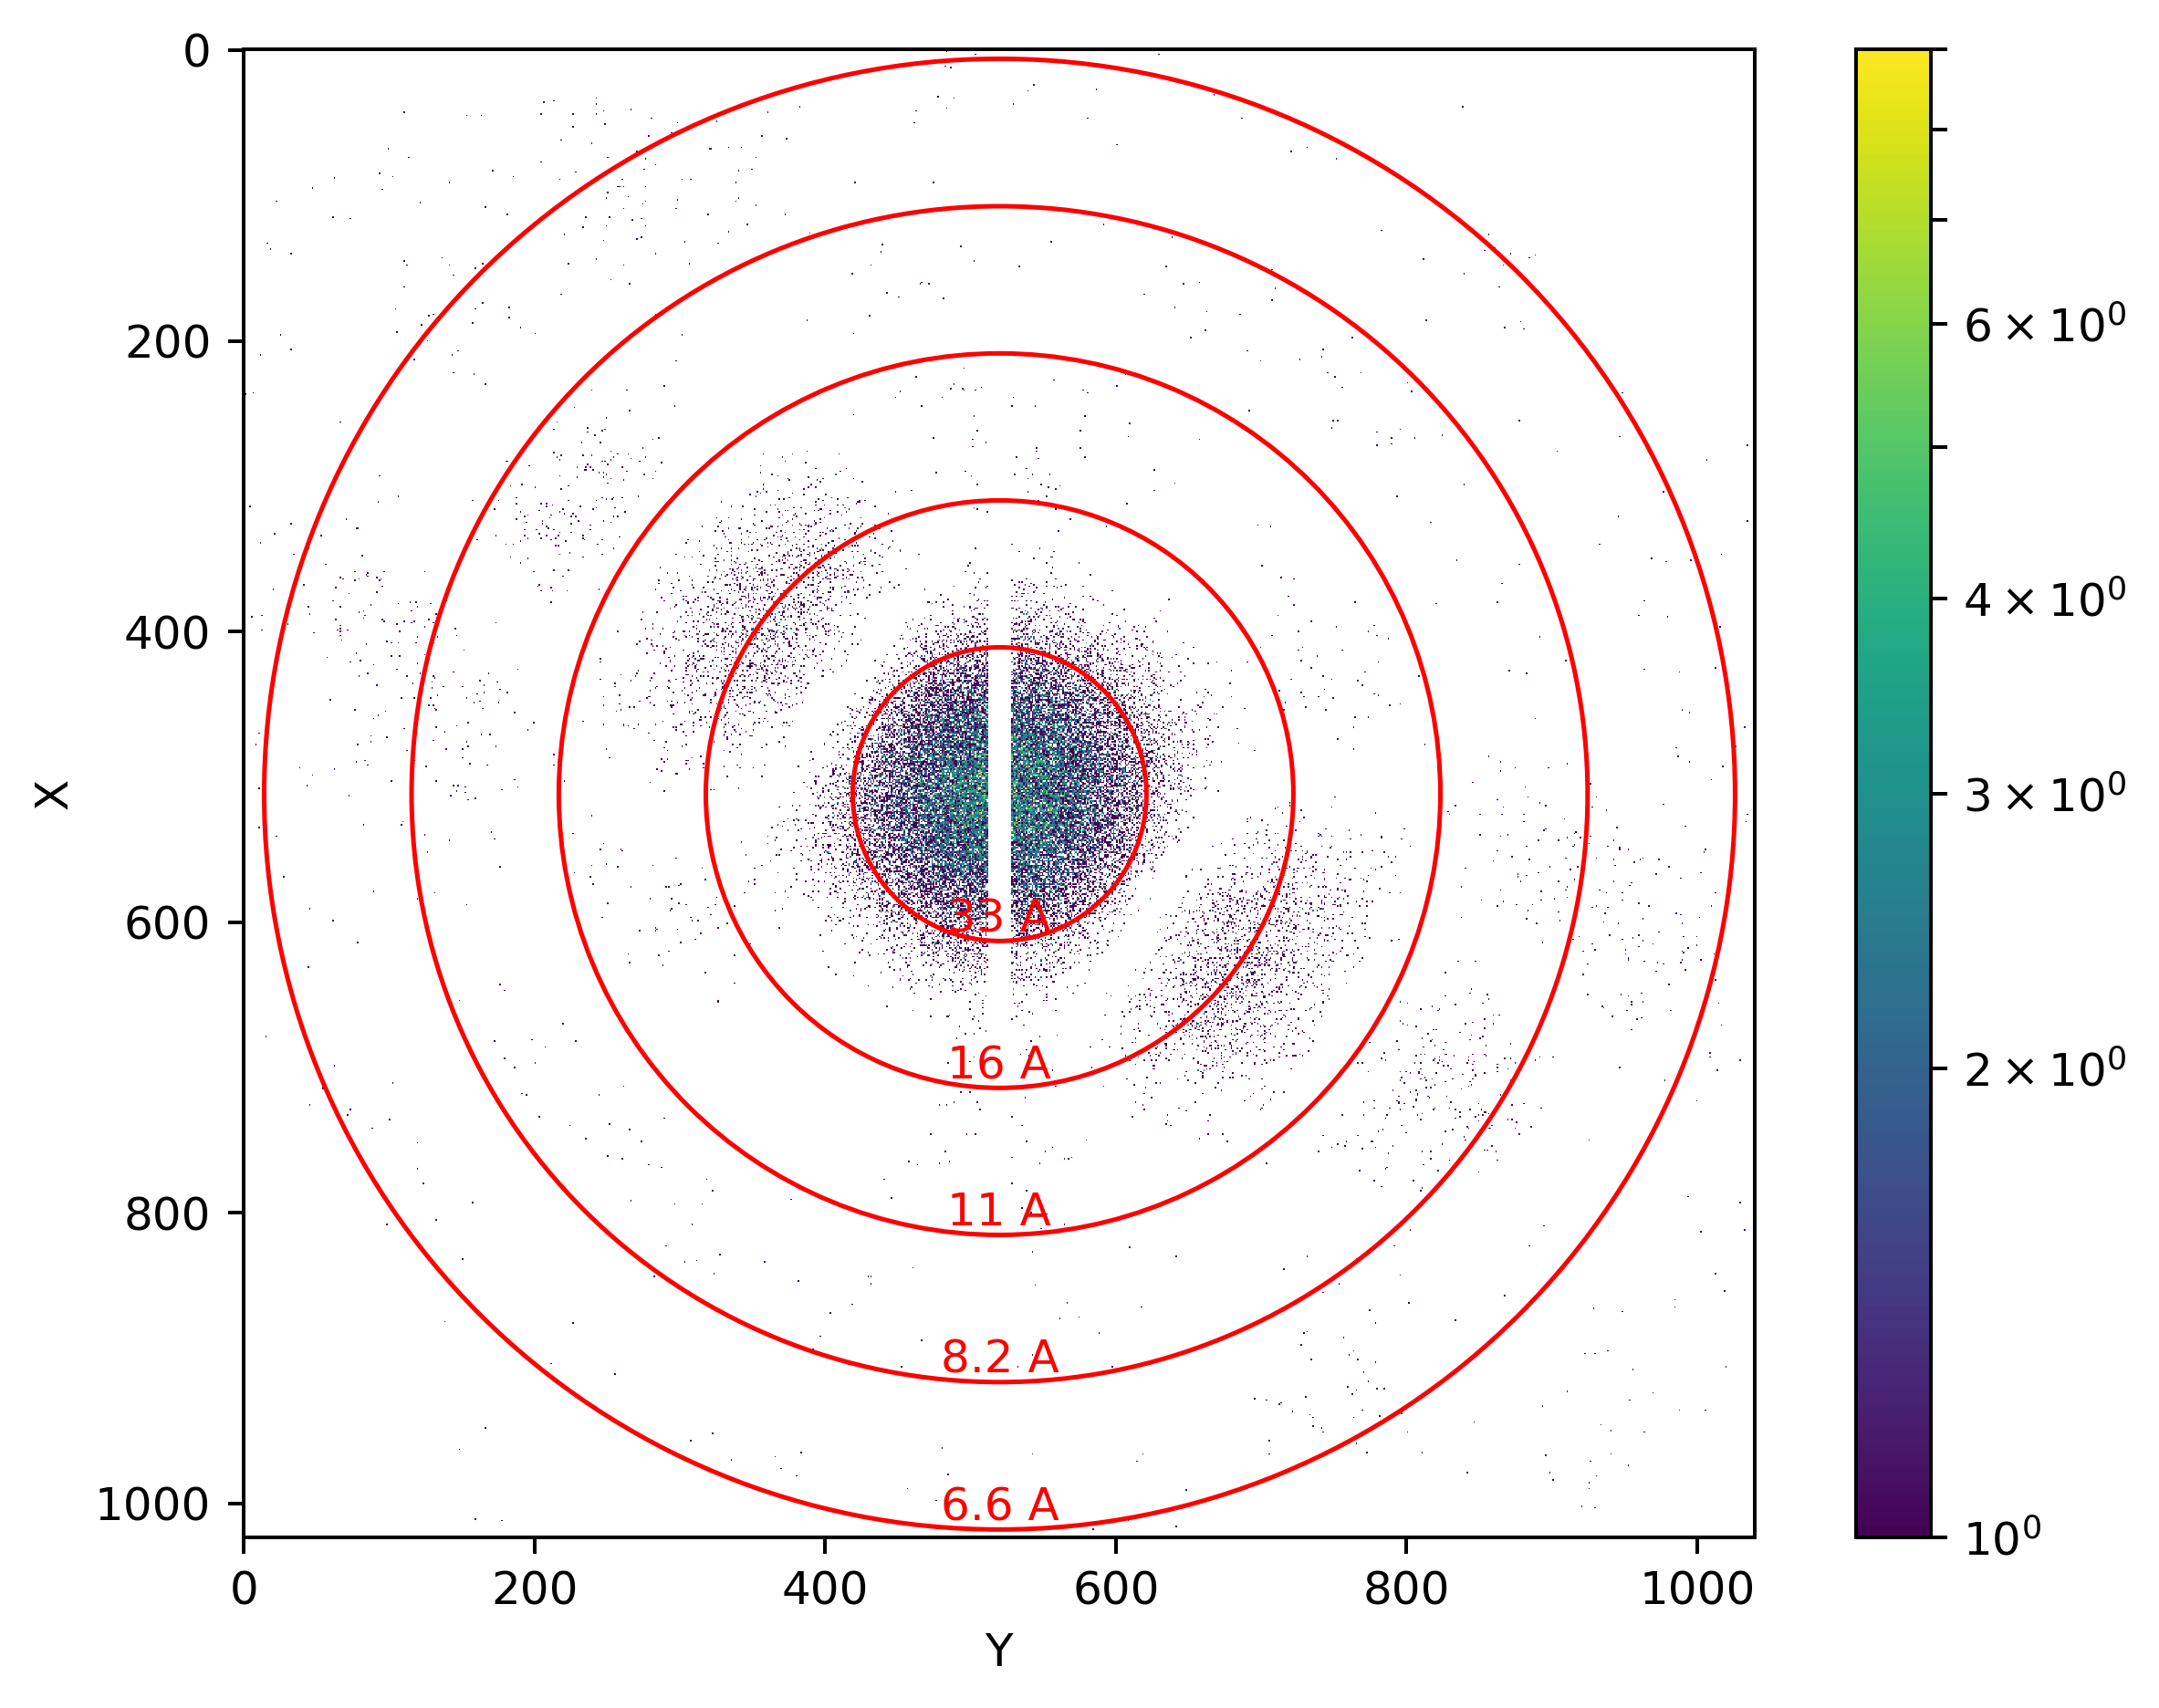

In [20]:
fig = plt.figure(figsize=(8, 6), dpi=180)
viz.imshow(experiment.generate_image())

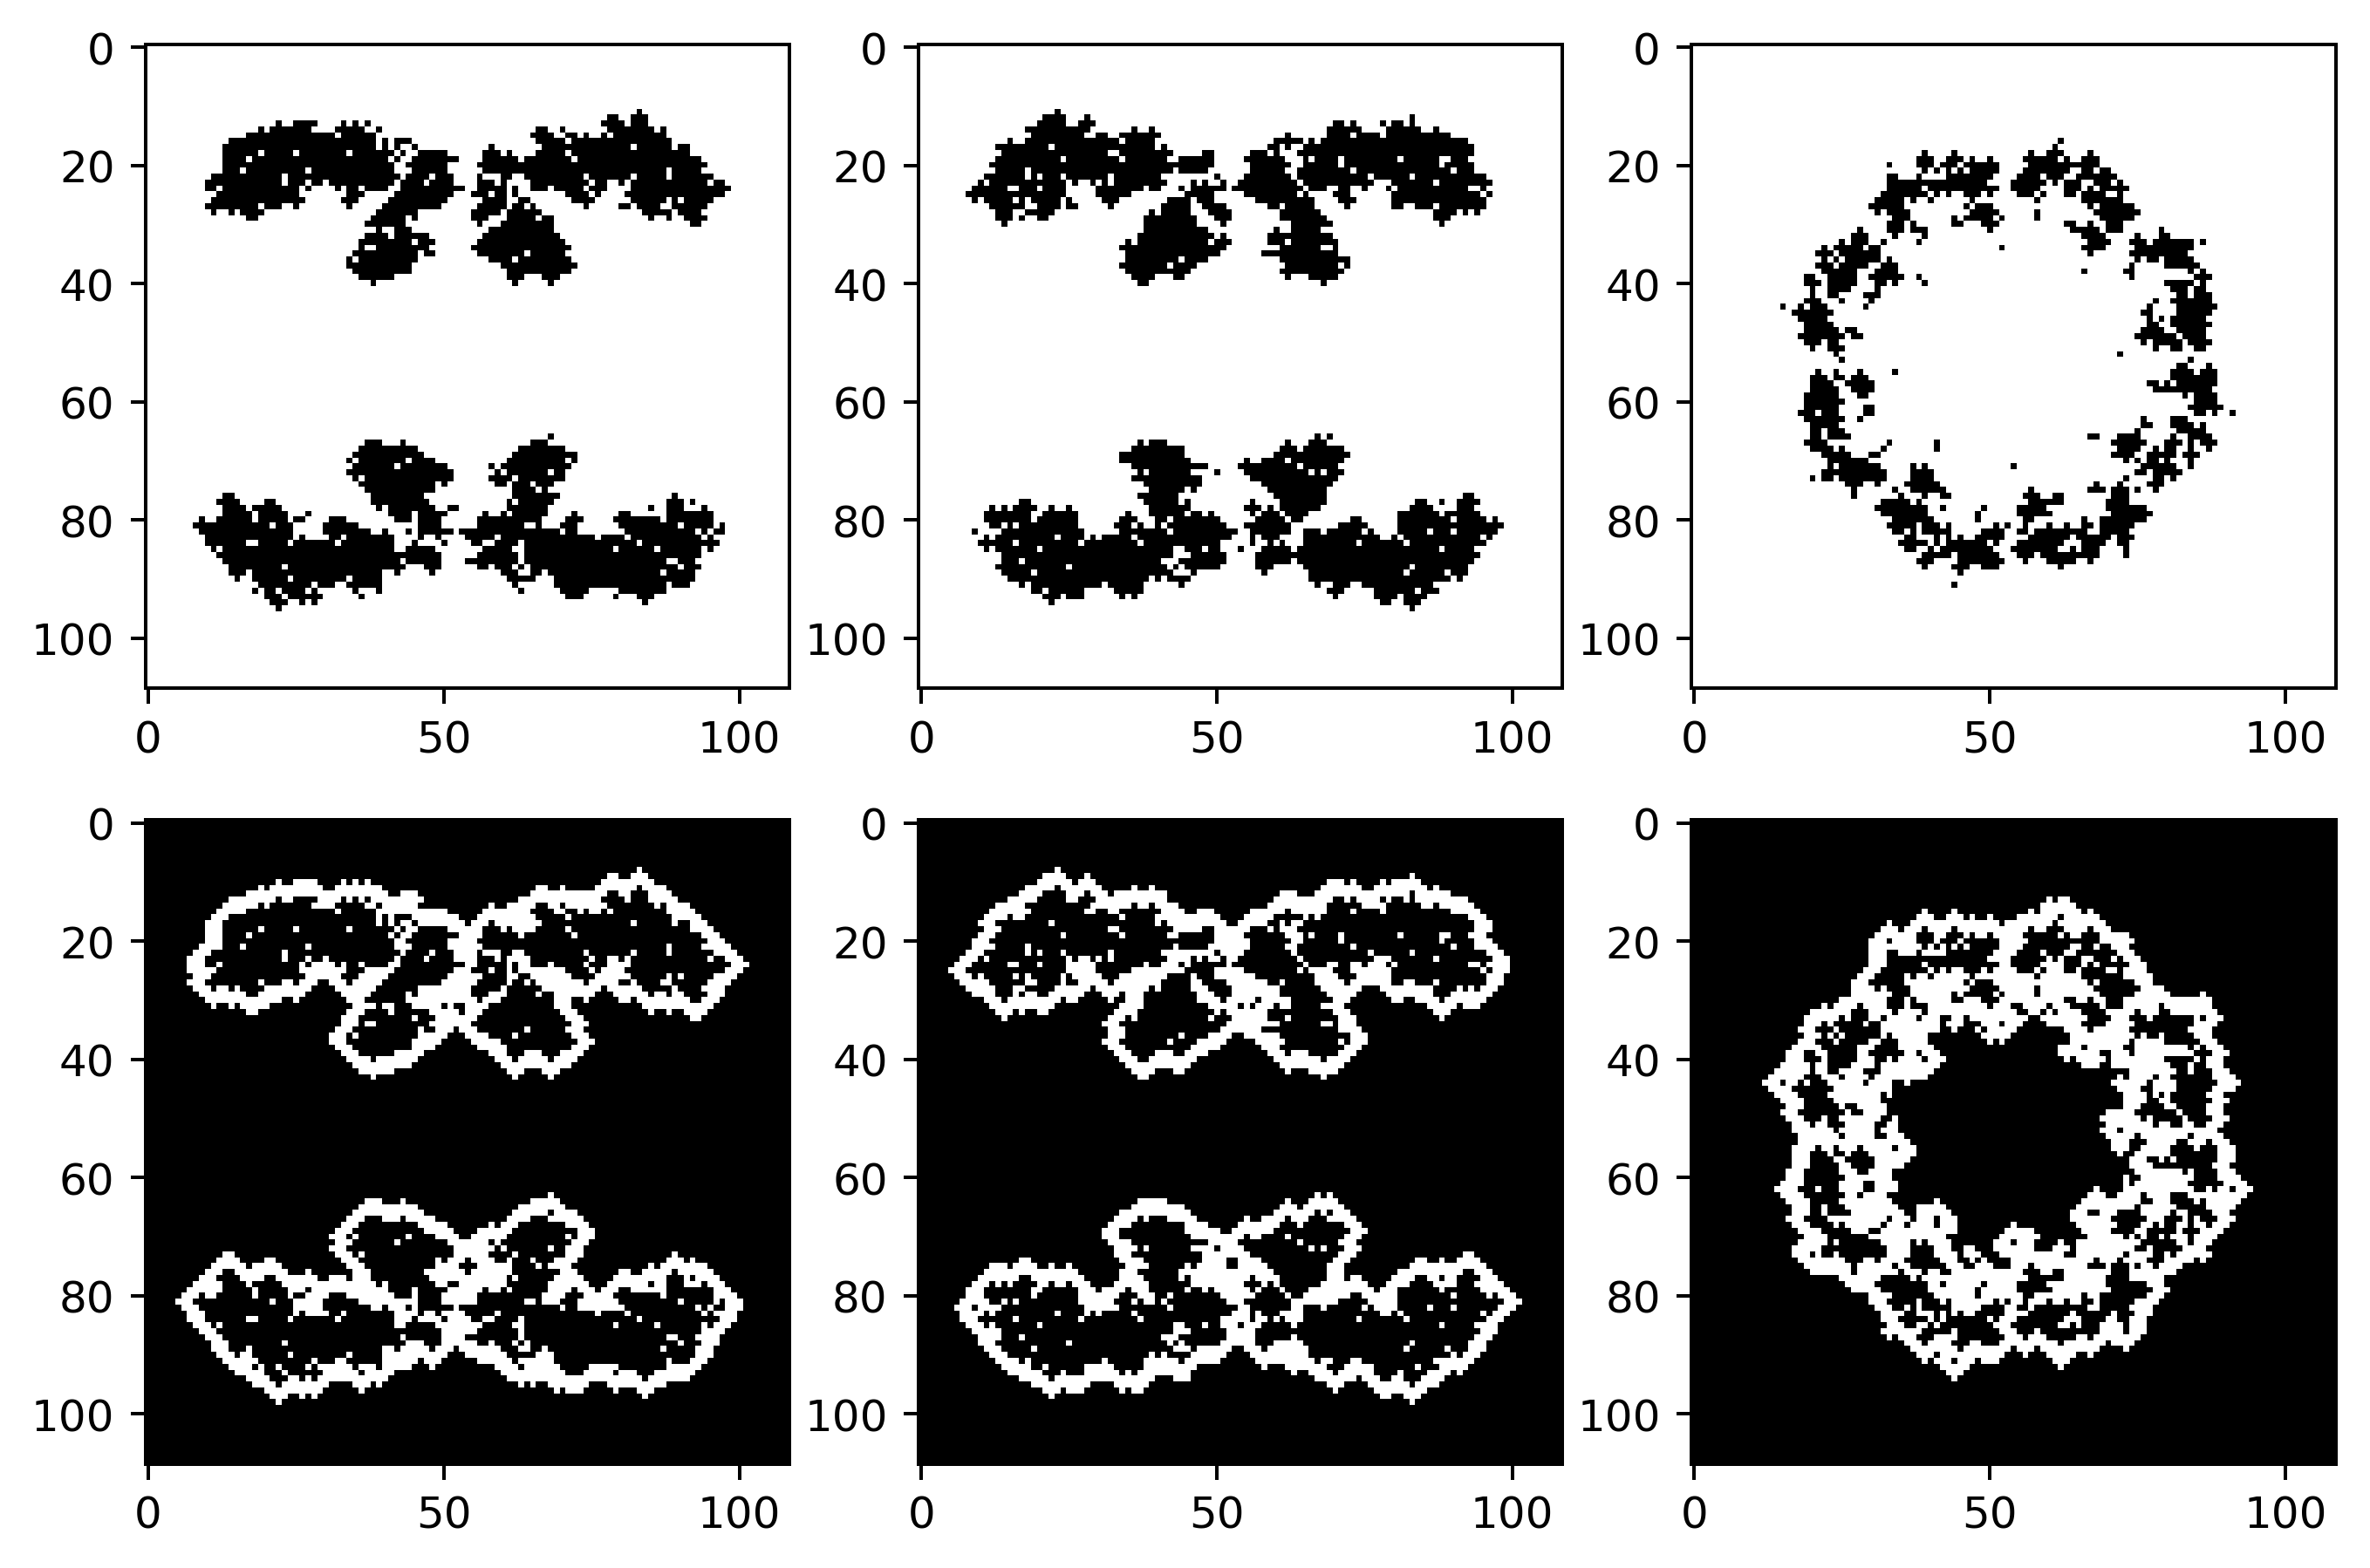

In [21]:
islice=np.floor(particle.mesh.shape[0]/2).astype('int')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9,6), dpi=180)
axes[0,0].imshow(particle.solute_mask[islice,...]*1, cmap='Greys_r')
axes[0,1].imshow(particle.solute_mask[:,islice,:]*1, cmap='Greys_r')
axes[0,2].imshow(particle.solute_mask[:,:,islice]*1, cmap='Greys_r')
axes[1,0].imshow(particle.solvent_mask[islice,...]*1, cmap='Greys_r')
axes[1,1].imshow(particle.solvent_mask[:,islice,:]*1, cmap='Greys_r')
axes[1,2].imshow(particle.solvent_mask[:,:,islice]*1, cmap='Greys_r')
plt.show()